In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, fft2, ifft2, ifftshift, fftfreq
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from matplotlib import rc
import matplotlib
from scripts.custom_functions import *
from tqdm import tqdm
import cmath as cm
from scripts.custom_functions import *

matplotlib.rcParams['font.size'] = 24
rc('font',**{'family':'fantasy','fantasy':['xkcd']})
rc('text', usetex=True)

xlabel_ds = 'Time [s]'
ylabel_ds = 'Frequency [Mhz]'
xlabel_ss = 'Doppler frequency [mHz]'
ylabel_ss = 'Time delay [ms]'

## General method to compute simulated spectra

In [2]:
N = 256         # size of the square dynamic and secondary spectra
NF = 4096       # number of input magnification "fluxes" from flux.dat file

flux = np.loadtxt('/mnt/scratch-lustre/bdesy/b0834/data/from_outside/simulation/flux.dat')

i=np.linspace(0,NF-1,NF)
x = (i-NF/2)/(NF/2)
ix = (N/4 * x + N/2).astype(int) 
iy = ((N-1) * x**2).astype(int)
phases = np.linspace(-np.pi, np.pi, NF)   # all the possible phases are between -pi and pi to have a gradient

cspec = np.zeros((N,N),dtype=np.complex_)
for ii in range(NF):
    cspec[ix[ii], iy[ii]] += cm.rect(np.sqrt(np.abs(flux[ii])), phases[ii]) 
rspec = ifft2(ifftshift(cspec))
Rspec = np.abs(rspec)**2
Rspec = Rspec*N**2/sum(Rspec)    # Real, dynamic spectrum
Rspec, rspec = Rspec.T, rspec.T  # Transposing to get the axes right
Cspec = fftshift(fft2(Rspec))    # Conjugate spectrum
a = 0.000048   # parabola's aperture (by eye, finding a way to compute it from the axes/parameter?)

In [3]:
Cspec.shape

(256, 256)

Here are the values of magnification input into the speckle parabola. Most of them are at 0.

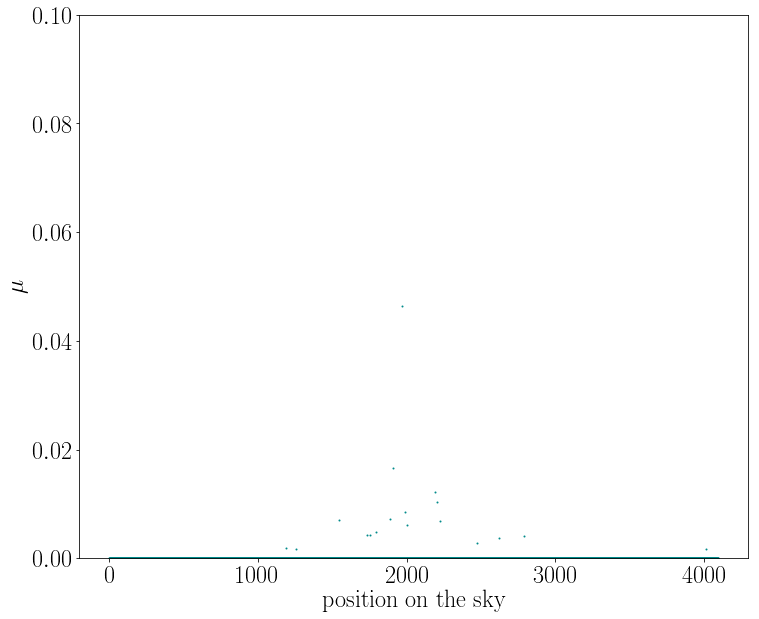

In [4]:
fig=plt.figure(figsize=(12,10))
plt.plot(flux, 'o', ms=1, c='darkcyan')
plt.xlabel('position on the sky')
plt.ylabel('$\mu$')
plt.ylim(0., 0.1)
plt.show()

Setting arbitrary axis to use Arclet object

In [5]:
freq = (np.arange(N)*8./N+310.5)     # Frequency band of 8 MHz starting at 310.5
time = np.arange(N)*10               # Time span of 2560 seconds
doppler = (fftshift(fftfreq(N))*1./ np.diff(np.array(time)).mean())*1e3     # doppler in mHz
delay = (np.arange(N)-N/2)*1./(8.0e6)*1e3                                   # delay in ms
delayh = delay[len(delay)/2:]

In [6]:
# initializing extents of axis we use the most
extent_ds = [time[0], time[-1], freq[0], freq[-1]]                       
extent_ss = [doppler[0], doppler[-1], delay[len(delay)/2], delay[-1]]    # SS, only positive delay
fextent_ss = [doppler[0], doppler[-1], delay[0], delay[-1]]              # SS, full extent

All the values of magnification are mapped into a parabolic shape

cspec

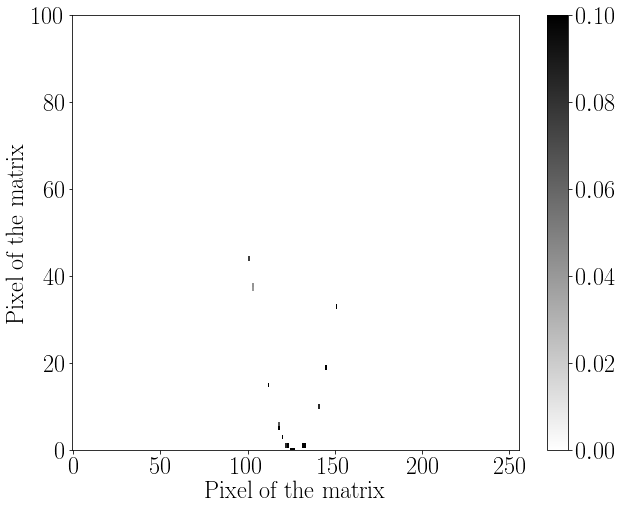

In [7]:
fig = plt.figure(figsize=(10,8))
plt.imshow(np.absolute(cspec.T), aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=0.1)
plt.colorbar()
plt.ylim(0, 100)
plt.xlabel('Pixel of the matrix')
plt.ylabel('Pixel of the matrix')
plt.show(block=False)

By inverse Fourier transforming this input speckle parabola, we obtaina first complex very low intensity spectrum.

rspec = ifft2(ifftshift(cspec))

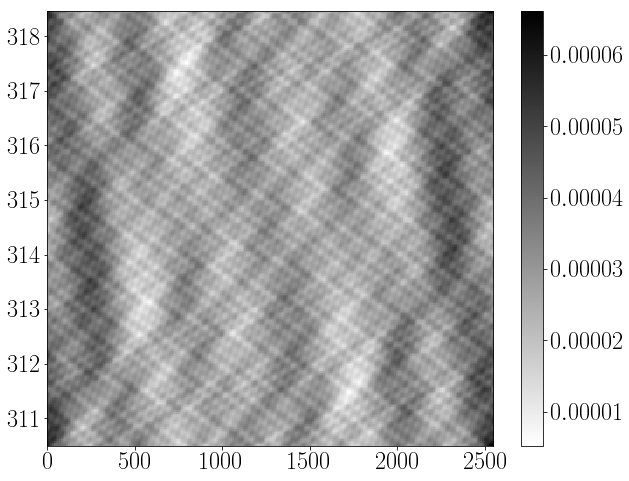

(256, 256)

In [8]:
fig = plt.figure(figsize=(10,8))
plt.imshow(np.abs(rspec), cmap='gray_r', origin='lower', extent=extent_ds, aspect='auto')
plt.colorbar()
plt.show(block=False)
rspec.shape

We then square the spectrum and normalize it to have higher intensity values.

Rspec = np.abs(rspec)** 2

Rspec = Rspec * N ** 2/sum(Rspec) 

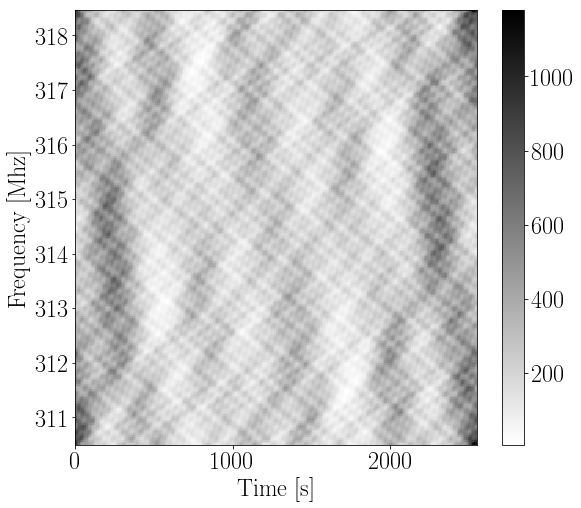

(256, 256)

In [9]:
fig = plt.figure(figsize=(9,8))
plt.imshow(Rspec, cmap='gray_r', origin='lower', extent=extent_ds, aspect='auto')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.show(block=False)
Rspec.shape

Then, by taking the FFT of the dynamic spectrum, we obtain the simulated conjugate spectrum.

Cspec = fftshift(fft2(Rspec))  

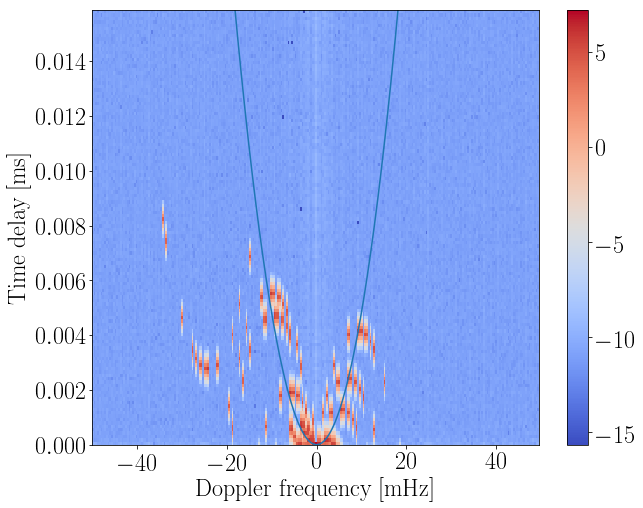

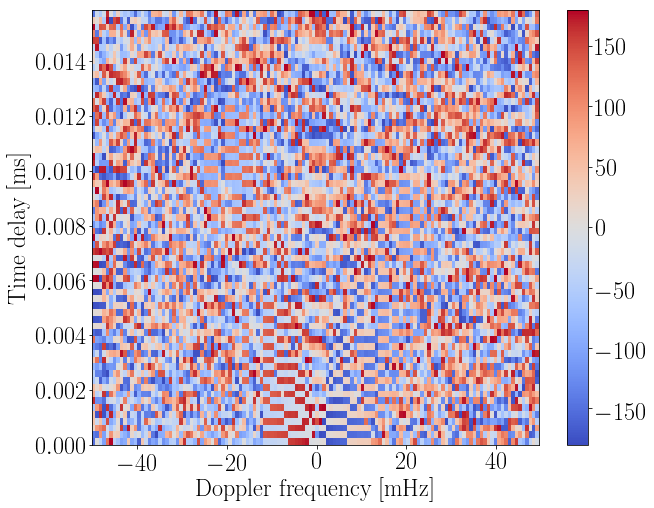

In [10]:
p2=plt.figure(figsize=(10,8))
plt.imshow(np.log10(np.abs(Cspec) + np.finfo(float).eps)[Cspec.shape[0]/2:, :],
           origin='lower', aspect='auto', cmap='coolwarm',
           extent=[doppler[0], doppler[-1], delay[len(delay)/2], delay[-1]])

plt.plot(doppler, a*doppler**2, '-')
plt.ylim(0., delay[-1])
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
plt.colorbar()
plt.show(block=False)


p3=plt.figure(figsize=(10,8))
pltang = binning(np.angle(Cspec, deg=True), 1, 1)
plt.imshow(pltang[pltang.shape[0]/2:pltang.shape[0]*3/4, pltang.shape[1]/4:pltang.shape[1]*3/4], 
           cmap='coolwarm', aspect='auto', origin='lower',
           extent=extent_ss)
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
plt.colorbar()
plt.show(block=False)

We see that the phases undergo a very sharp change. By woking with N >> 256, we might achieve a gradient of phases into the arclets that is more smooth and similar to the observational data. 

### Studying an arclet 

Defining coordinate of the arclet on the conjugate spectrum [doppler, delay, width], and notation SS for secondary spectrum and ftI for conjugate spectrum. Furthermore, we need a version of the conjugate spectrum where the middle rows and columns have been set to zero, noted ftI_00ed here.

In [11]:
last_apex = [9.2, 0.0041, 0.0016]

SS = np.absolute(Cspec)**2#*np.conj(Cspec)
ftI = Cspec

ftI_00ed = np.copy(Cspec)
ftI_00ed[ftI_00ed.shape[0]/2, :] = 0
ftI_00ed[:, ftI_00ed.shape[1]/2] = 0

In [12]:
class Arclet(object):
    def __init__(self, name, apex, hw, vw, rect=[0,0], a=None):
        '''
        params : 
        name (string) is only used when printing the object
        apex (list [doppler coordintate, delay coordinate, width]) 
             width used if instanciating arclets of different widths in a loop
        hv   (float) horizontal width in mHz, from the apex to one end of the arclet
        vw   (float) vertical width in ms at apex of arclet if using default aperture a 
             or all across the arclet if other aperture
        rect (list [width in mHz, height in ms]) a rectangle that hides the part of the mask near the origin
        a    (float) to precise parabola aperture for the arclet, 
             otherwise it defines upper and lower parabolas that aim at 0
        return :
        self.coordo =  [apex, hw, vw] to access after instanciation
        self.mask : mask covering the arclet, minimal infomation is the apex coordinates and width
                    for a mask that gets thinner, or if precised aperture constant thickness
        self.mask_00 : exact same mask centered at origin
        self.name used for priting the object
        '''
        self.coordo = [apex, hw, vw]
        self.mask = get_mask(doppler, delay, apex, fhw=hw, fvw=vw, rect=rect, a=a) #mask centered at apex
        self.name = name
        
        mask_flip = np.flipud(np.fliplr(self.mask))
        yroll = np.argmin(abs(delay-self.coordo[0][1]))-len(delay)/2 
        xroll = np.argmin(abs(doppler-self.coordo[0][0]))-len(doppler)/2 
        self.mask_00 = np.roll(np.roll(mask_flip,yroll+1,0), xroll+1,1)  # same mask centered at [0,0]
    
    def __repr__(self):
        '''print function for output of a print(Arclet object) command'''
        return self.name + ' Arclet object at ' + str(self.coordo[0][0]) + ' mHz f_D and ' + str(self.coordo[0][1]) + ' ms delay'
    
    # We define both ratios from conjugate spectrum and secondary spectrum, 
    #  they differs but see last section of notebook about how their difference is related to noise
    
    def get_ratio_cs(self):
        '''
        return :
        self.ratio_cs : square of magnification ratio from the conjugate spectrum
        self.flux_cs = flux of arclet on conjugate spectrum
        self.flux_ref_cs = flux of shape of arclet on main parabola of conjugate spectrum
        '''
        self.flux_cs = np.sum(np.absolute(ftI)*self.mask)
        self.flux_ref_cs = np.sum(np.absolute(ftI)*self.mask_00)
        self.ratio_cs = (self.flux_cs/self.flux_ref_cs)**2.
       
    def get_ratio_ss(self):
        '''
        return :
        self.ratio_ss : magnification ratio from the secondary spectrum
        self.flux_ss = flux of arclet on secondary spectrum
        self.flux_ref_ss = flux of shape of arclet on main parabola of secondary spectrum
        '''
        self.flux_ss = np.sum(np.absolute(SS)*self.mask)
        self.flux_ref_ss = np.sum(np.absolute(SS)*self.mask_00)
        self.ratio_ss = (self.flux_ss/self.flux_ref_ss)
    
    def get_ds(self):
        '''
        return : 
        self.cs_apex : conjugate spectrum of arclet only, at position of apex
        self.cs_origin : conjugate spectrum of arclet only, rolled to the origin
        self.green : iFFT of cs_origin
        self.ds : square modulus of green
        '''
        self.cs_apex = ftI*self.mask                # to plot it and double-checking
        yroll = -np.argmin(abs(delay-self.coordo[0][1]))-len(delay)/2 
        xroll = -np.argmin(abs(doppler-self.coordo[0][0]))-len(doppler)/2 
        self.cs_origin = np.roll(np.roll(self.cs_apex, yroll, 0), xroll, 1)  # to plot it and double-checking
        self.green = ifft2(ifftshift(self.cs_origin))
        self.ds = np.absolute(self.green*np.conjugate(self.green))    # np.absolute just to remove the 0j term
        
    def deconvolve(self):
        '''
        return :
        self.I : dynamic spectrum obtained from iFFT the conjugate spectrum 
                    with the middle row and column set to 0
        self.deconvolved_ds : I * e^(-i *phases of green)
        self.deconvolution : FFT of deconvolved_ds (no resetting of gaps and contour to 0)
        '''
        self.I = ifft2(ifftshift(ftI_00ed))
        self.deconvolved_ds = np.absolute(self.I)*np.exp(-1.0j*np.angle(self.green))
        self.deconvolution = fftshift(fft2(self.deconvolved_ds))
    
    def get_corr_ds(self, to='ds'):
        ''' 
        here we can correlate two things, either the dynamic spectrum or the green functione,
        use the tag to= to select. This outputs both correlation to initial data (self.corr_data) 
        and to the inverse FFT of the conjugate spectrum with zeroed power at middle rows and colums (self.corr_conj) 
        '''
        x = ifft2(ifftshift(ftI_00ed))
        if to == 'green':
            y = self.green
        elif to == 'ds':
            y = self.ds
        self.corr_conj = np.sum(  np.absolute(x-np.mean(x)) * np.absolute(y-np.mean(y))  ) \
                                /(np.sqrt(  np.sum(np.absolute(x-np.mean(x))**2)*np.sum(np.absolute(y-np.mean(y))**2))  )
        x = ifft2(ifftshift(ftI))
        self.corr_data = np.sum(  np.absolute(x-np.mean(x)) * np.absolute(y-np.mean(y))  ) \
                                /(np.sqrt(  np.sum(np.absolute(x-np.mean(x))**2)*np.sum(np.absolute(y-np.mean(y))**2))  )

In [13]:
larc = Arclet('last', last_apex, 8., 0.0016, a=-a)
larc.get_ds()
print(larc)

last Arclet object at 9.2 mHz f_D and 0.0041 ms delay


Plotting various arclet related things

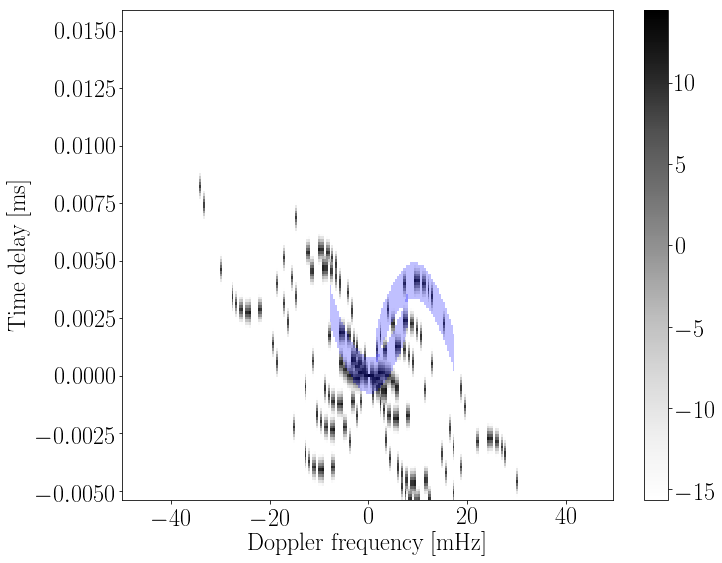

In [14]:
extent = [doppler[0], doppler[-1], delay[len(delay)/3], delay[-1]]

fig = plt.figure(figsize=(11,9))
plt.imshow(np.log10(np.absolute(SS)+np.finfo(float).eps)[ftI.shape[0]/3:, :],
             cmap='Greys', aspect='auto', origin='lower', extent=extent)
plt.colorbar()
plt.imshow(np.ma.masked_where(larc.mask == 0, larc.mask)[ftI.shape[0]/3:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent, alpha=0.25)
plt.imshow(np.ma.masked_where(larc.mask_00 == 0, larc.mask_00)[ftI.shape[0]/3:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent, alpha=0.25)
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
#plt.title('Mask of arclet on conjugate spectrum')
plt.show()

Here, $G_{arc}$ denotes the Green function

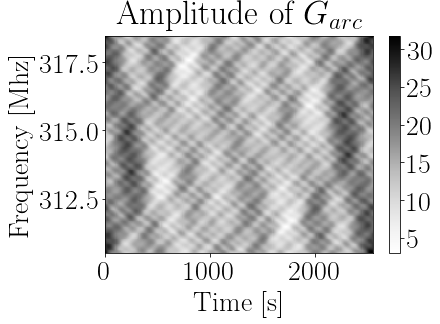

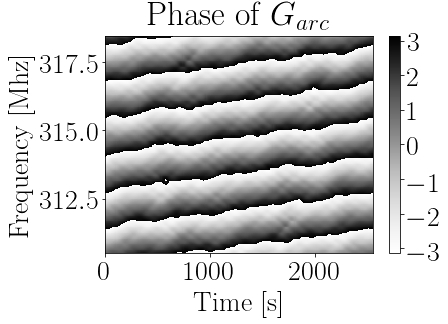

In [19]:
plt.imshow(np.absolute(larc.green), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.title(r'Amplitude of $G_{arc}$')
plt.colorbar()
plt.show()
plt.imshow(np.angle(larc.green), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title(r'Phase of $G_{arc}$')
plt.show()

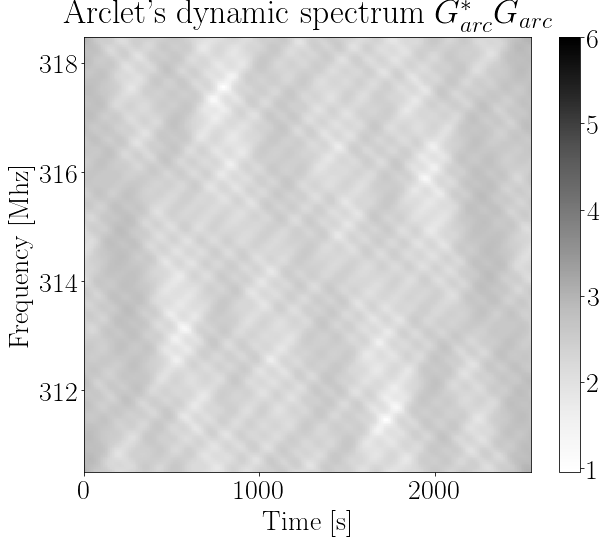

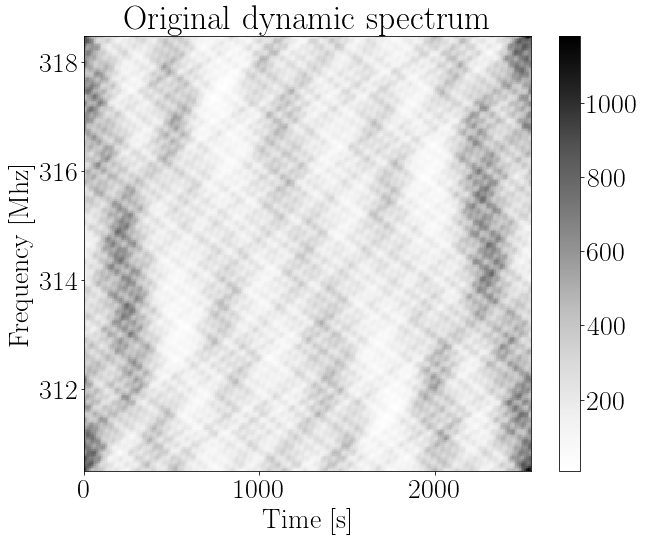

Pearson's correlation coefficient = 0.969706507028


In [20]:
fig=plt.figure(figsize=(10,8))
plt.imshow(np.log10(np.absolute(larc.ds)), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys', vmax=6)
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.title('Arclet\'s dynamic spectrum $G_{arc}^*G_{arc}$')
plt.colorbar()
plt.show()
fig=plt.figure(figsize=(10,8))
plt.imshow(Rspec, 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.title('Original dynamic spectrum')
plt.colorbar()
plt.show()

larc.get_corr_ds(to='ds')
print('Pearson\'s correlation coefficient = ' + str(larc.corr_data))

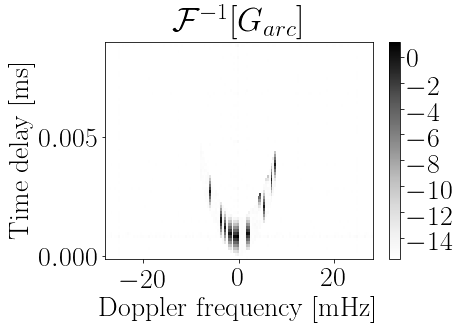

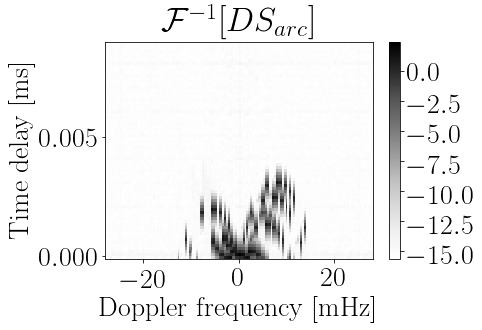

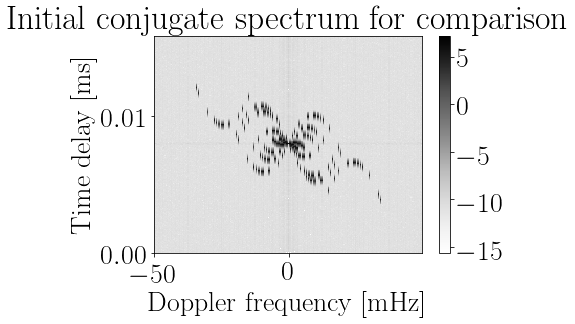

((256, 256), (256, 256))

In [21]:
recovered_arclet_cs = ifftshift(ifft2(larc.green))
extent_5 = [doppler[56], doppler[200], delay[127], delay[200]]
plt.imshow(np.log10(np.absolute(recovered_arclet_cs)+np.finfo(float).eps)[127:200, 56:200], 
           aspect='auto', origin='lower', extent=extent_5, cmap='Greys')
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
plt.colorbar()
plt.title(r' $\mathcal{F}^{-1}[G_{arc}]$')
plt.show()

plt.imshow(np.log10(np.absolute(ifftshift(ifft2(larc.ds)))+np.finfo(float).eps)[127:200, 56:200], 
           aspect='auto', origin='lower', extent=extent_5, cmap='Greys')
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
plt.colorbar()
plt.title(r' $\mathcal{F}^{-1}[DS_{arc}]$')
plt.show()

plt.imshow(np.log10(np.absolute(Cspec)+np.finfo(float).eps), 
           aspect='auto', origin='lower', extent=extent_ss, cmap='Greys')
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
plt.title(r'Initial conjugate spectrum for comparison')
plt.colorbar()
plt.show()
larc.cs_apex.shape, ftI.shape

## Trial of deconvolution with last arclet (larc)

In [22]:
larc.deconvolve()

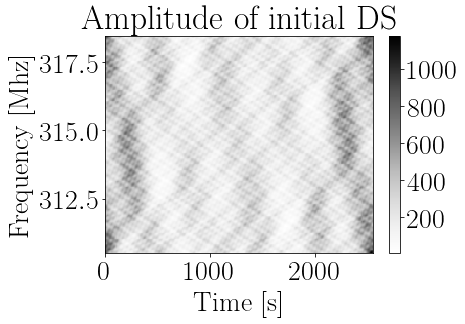

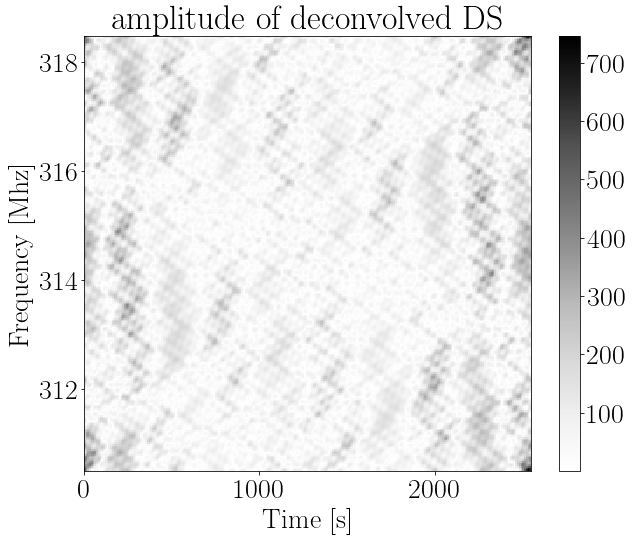

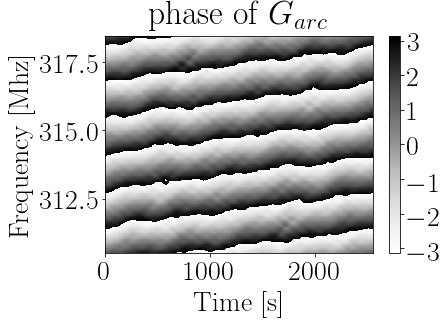

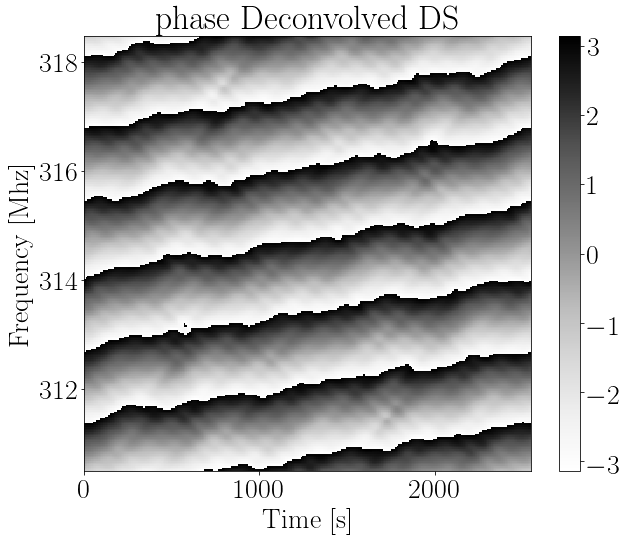

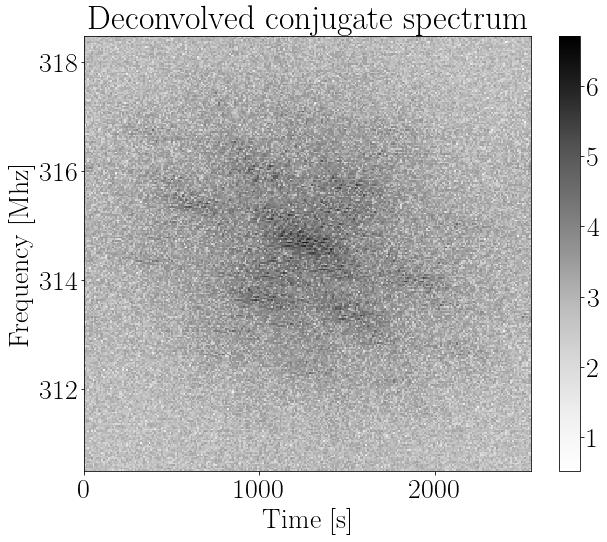

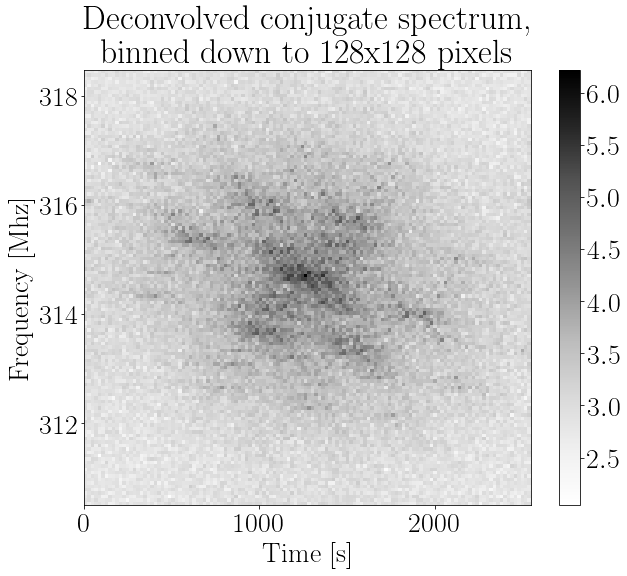

In [23]:
plt.imshow(np.absolute(Rspec), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title(r'Amplitude of initial DS')
plt.show() 

fig = plt.figure(figsize=(10,8))
plt.imshow(np.absolute(larc.deconvolved_ds), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title('amplitude of deconvolved DS')
plt.show() 

plt.imshow(np.angle(larc.green), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title('phase of $G_{arc}$')
plt.show() 

fig = plt.figure(figsize=(10,8))
plt.imshow(np.angle(larc.deconvolved_ds), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title(' phase Deconvolved DS')
plt.show() 


fig = plt.figure(figsize=(10,8))
plt.imshow(np.log10(binning(np.absolute(larc.deconvolution), 1,1)), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title('Deconvolved conjugate spectrum')
plt.show() 

fig = plt.figure(figsize=(10,8))
plt.imshow(np.log10(binning(np.absolute(larc.deconvolution), 2, 2)), 
           aspect='auto', origin='lower', extent=extent_ds, cmap='Greys')
plt.xlabel(xlabel_ds)
plt.ylabel(ylabel_ds)
plt.colorbar()
plt.title('Deconvolved conjugate spectrum,\n binned down to 128x128 pixels')
plt.show() 

### Relating an arclet to its input magnification

Location of arclet and notation. First I locate which pixels contain the speckle. 

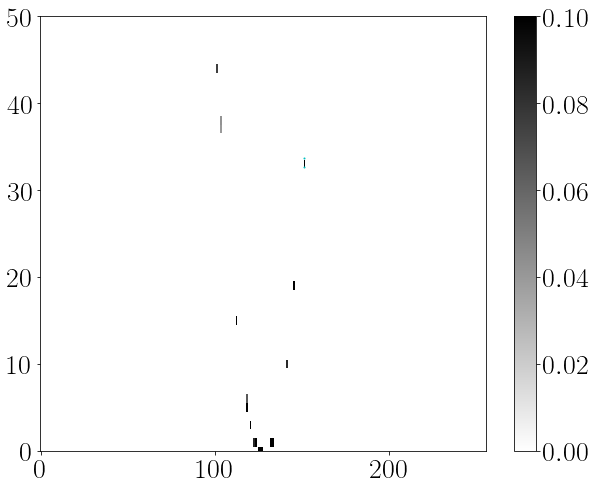

In [24]:
fig = plt.figure(figsize=(10,8))
plt.imshow(np.abs(cspec.T), aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=0.1)
plt.plot(151, 32.7, 'co', ms=1)
plt.plot(151, 33.7, 'co', ms=1)
plt.colorbar()
plt.ylim(0, 50)
plt.show(block=False)

To find which magnification are into this pixel, we find which indices correspond the x coordinate 151 and the y coordinate between 32.7 and 33.7.

In [25]:
 iy[2775:2805]

array([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34])

In [26]:
ix[2775:2805]

array([150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151,
       151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151,
       151, 151, 151, 151])

In [27]:
flux[2775:2805]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.0037823 ,  0.        ,  0.00406193,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

It turns out that more than one image is "inputed" for that particular arclet (and most of them). To know which is the input magnification exactly, we need to add the complex images. 

In [28]:
amp1 = flux[2790]
amp2 = flux[2792]
phi1 = phases[2790]
phi2 = phases[2792]

mus = np.array([amp1*np.exp(1.0j*phi1), amp2*np.exp(1.0j*phi2)], dtype=complex)
np.absolute(mus[0]+mus[1])  # total magnification input into the speckle

0.00027988477485330591

#### Question : Since these images are waves, would'nt they rather interfere, a.k.a not add up linearly?

In [29]:
# defining a function to do this more quickly
def sum_images(index1, index2):
    mus = np.array([flux[index1]*np.exp(1.0j*phases[index1]), flux[index2]*np.exp(1.0j*phases[index2])], dtype=complex)
    return np.absolute(mus[0]+mus[1])

### Masks method to get ratios

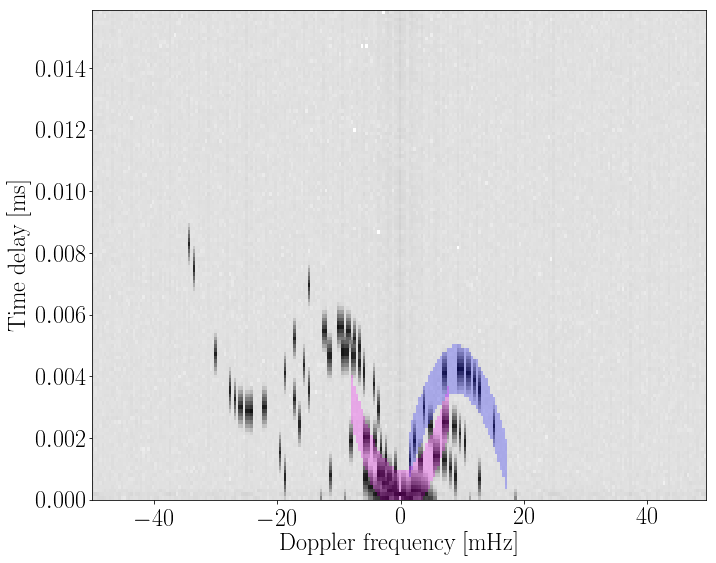

Ratio on conjugate spectrum : 0.00148607100405
 Ratio on secondary spectrum : 0.00312681335818
 Ratio from mean of DS/mean of initial DS : 0.983289425446


In [15]:
larc.get_ratio_ss()
larc.get_ratio_cs()
fig=plt.figure(figsize=(11,9))
plt.imshow(np.log10(np.absolute(ftI)+np.finfo(float).eps)[127:,],
             cmap='Greys', aspect='auto', origin='lower', extent=extent_ss)
plt.imshow(np.ma.masked_where(larc.mask == 0, larc.mask)[127:,], 
           cmap='winter', aspect='auto', origin='lower', extent=extent_ss, alpha=0.25)
plt.imshow(np.ma.masked_where(larc.mask_00 == 0, larc.mask_00)[127:,], 
           cmap='spring', aspect='auto', origin='lower', extent=extent_ss, alpha=0.25)
plt.xlabel(xlabel_ss)
plt.ylabel(ylabel_ss)
plt.show()

print('Ratio on conjugate spectrum : {0}\n Ratio on secondary spectrum : {1}\n Ratio from mean of DS/mean of initial DS : {2}'.format(larc.ratio_cs, larc.ratio_ss, np.mean(larc.ds)/np.mean(Rspec)))

Let's try it with other arclets.

In [31]:
other_arclets_coordo = [[-9, 0.00475, 0.0016, 8.], 
                        [-9.7, 0.0056, 0.0016, 8.],  
                        [7.5, 0.00245, 0.0014, 7.]]

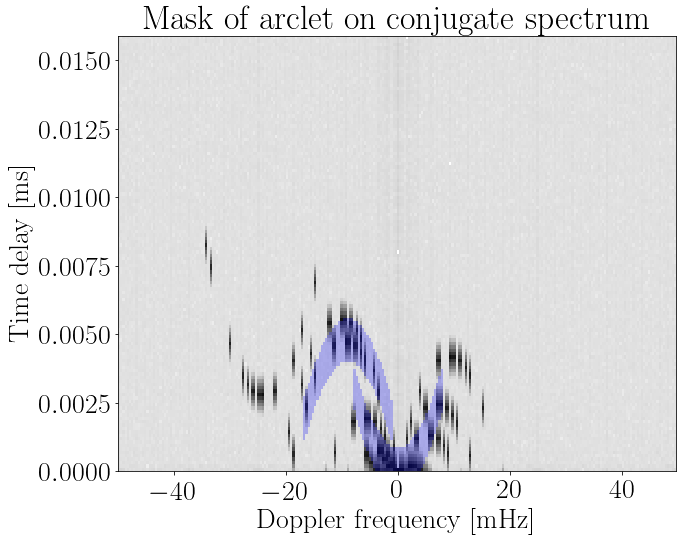

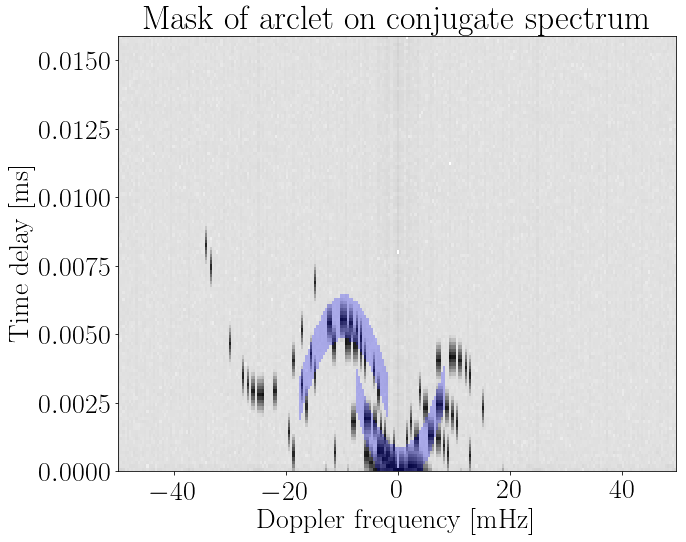

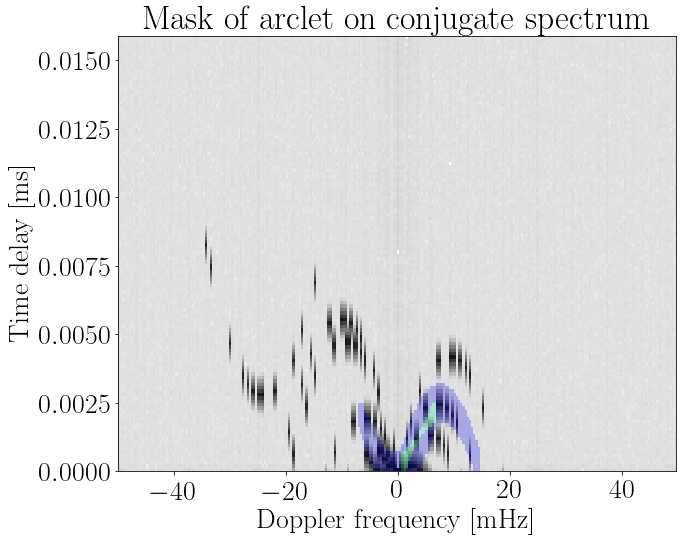

In [33]:
other_arclets = []
show=True
for i in range(len(other_arclets_coordo)):
    other_arclets.append(Arclet(str(i), other_arclets_coordo[i], other_arclets_coordo[i][3], other_arclets_coordo[i][2], a=-a))
    if show:
        fig=plt.figure(figsize=(10,8))
        plt.imshow(np.log10(np.absolute(ftI)+np.finfo(float).eps)[ftI.shape[0]/2:, :],
                     cmap='Greys', aspect='auto', origin='lower', extent=extent_ss)
        plt.imshow(np.ma.masked_where(other_arclets[i].both_masks == 0, other_arclets[i].both_masks)[ftI.shape[0]/2:, :], 
                   cmap='winter', aspect='auto', origin='lower', extent=extent_ss, alpha=0.25)
        plt.xlabel(xlabel_ss)
        plt.ylabel(ylabel_ss)
        plt.title('Mask of arclet on conjugate spectrum')
        plt.show()

In [34]:
print(' f_D position        ratio CS      ratio SS       color on plot')
colors = ['green', 'yellow', 'pink']
for arc in other_arclets:
    arc.get_ratio_cs()
    arc.get_ratio_ss()
    print('    {0}            {1:.5}        {2:.5}       {3}'.format(arc.coordo[0][0], arc.ratio_cs, arc.ratio_ss, colors[other_arclets.index(arc)]))

 f_D position        ratio CS      ratio SS       color on plot
    -9            0.0010748        0.00075609       green
    -9.7            0.00063519        0.0011352       yellow
    7.5            0.0061994        0.017662       pink


We can observe that the ratios computed on the CS and SS doesn't correspond to each other, this need more investigation.

Locating which magnifications were used as input.

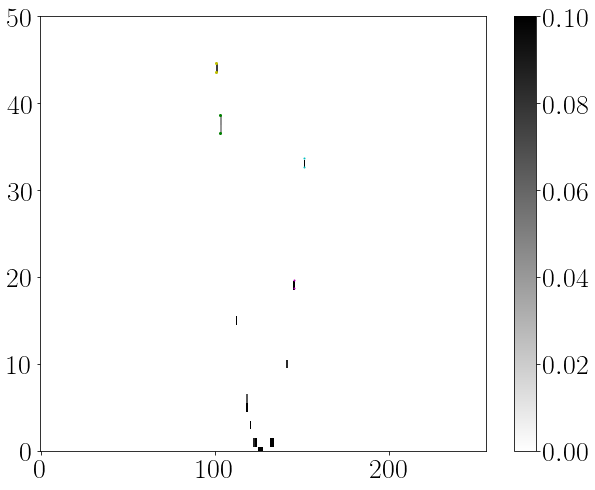

In [35]:
fig = plt.figure(figsize=(10,8))
plt.imshow(np.abs(cspec.T), aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=0.1)
plt.plot(151, 32.7, 'co', ms=1)
plt.plot(151, 33.7, 'co', ms=1)
plt.plot(145, 18.7, 'mo', ms=1)
plt.plot(145, 19.7, 'mo', ms=1)
plt.plot(100.6, 43.6, 'yo', ms=2)
plt.plot(100.6, 44.6, 'yo', ms=2)
plt.plot(103, 38.6, 'go', ms=2)
plt.plot(103, 36.6, 'go', ms=2)
plt.colorbar()
plt.ylim(0, 50)
plt.show(block=False)

In [36]:
# pink speckle at pixels 145, 19
i1 = 2618
i2 = 2621
print('values of magnification input : {0} and {1}\ntotal magnification (summed as complex number with phases) : {2}'.format(flux[i1], flux[i2], sum_images(i1, i2)))
flux[2580:2660], 

values of magnification input : -0.00194360383941 and 0.00371188387219
total magnification (summed as complex number with phases) : 0.00176832325524


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.0019436 ,  0.        ,
         0.        ,  0.00371188,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [37]:
# yellowish speckle at 100, 45,
i1 = 1191
i2 = 1195
print('values of magnification input : {0} and {1}\ntotal magnification (summed as complex number with phases) : {2}'.format(flux[i1], flux[i2], sum_images(i1, i2)))
flux[1160:1220], 

values of magnification input : 0.00192658605942 and -0.000971101188352
total magnification (summed as complex number with phases) : 0.000955521748548


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00192659,  0.        ,  0.        ,  0.        ,
        -0.0009711 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),)

In [38]:
# green speckle at 103, 37
i1 = 1256
i2 = 1260
print('values of magnification input : {0} and {1}\ntotal magnification (summed as complex number with phases) : {2}'.format(flux[i1], flux[i2], sum_images(i1, i2)))
flux[1220 : 1300]

values of magnification input : 0.00179155919529 and -0.00157902960754
total magnification (summed as complex number with phases) : 0.000212780133283


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00179156,  0.        ,  0.        ,  0.        ,
       -0.00157903,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### Trial to hide more tau from the origin (to be tried on a smoother spectra)

In [39]:
taus = np.arange(42*3)*1./55000
arclets = [Arclet(str(int(tau*1000)), last_apex, 9, 0.0014, rect=[25., tau]) for tau in taus]
for a in arclets:
    a.get_ratio_ss()
ratios = [a.ratio_ss for a in arclets]

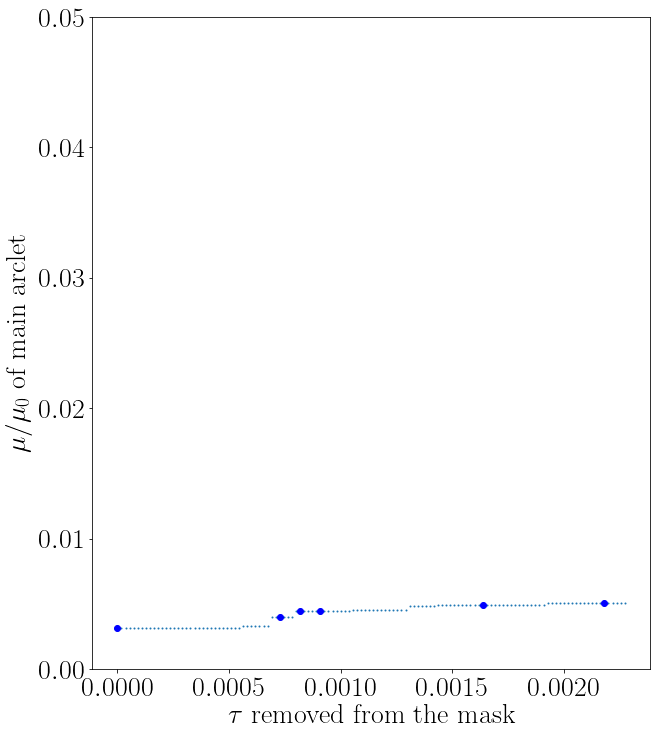

(0.0034197518375218851, 0.00047344376074311899)

In [40]:
indices = [0, 40, 45, 50, 90, 120]
fig = plt.figure(figsize=(10, 12))
plt.plot(taus, ratios, 'o', ms=1)
for i in indices:
    plt.plot(taus[i], ratios[i], 'bo')
plt.ylabel(r'$\mu/\mu_0$ of main arclet')
plt.xlabel(r'$\tau$ removed from the mask')
plt.ylim(0., 0.05)
plt.title(' ')
plt.show()
np.mean(ratios[:50]), np.std(ratios[:50])

This is much more dispersed than the equivalent on data. Each step correspond to many different values computed in the same pixel. Should be tried on a higher resolution and with a smoother spectrum.

/Users/beatrice/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


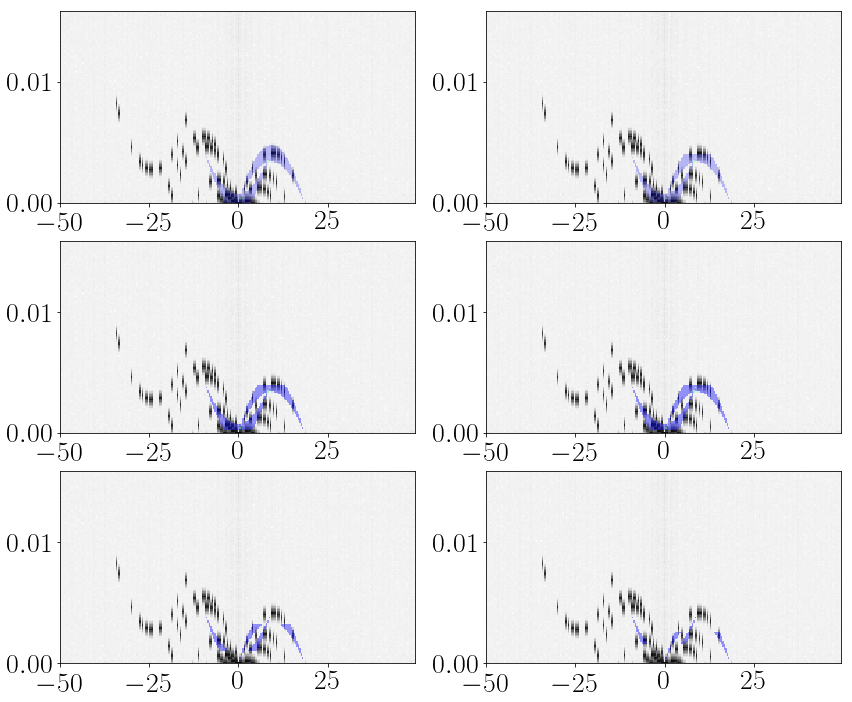

In [41]:
fig = plt.figure(figsize=(14, 12))
ax1, ax2, ax3, ax4, ax5, ax6 = fig.add_subplot(321), fig.add_subplot(322), fig.add_subplot(323), fig.add_subplot(324), fig.add_subplot(325), fig.add_subplot(326)
extent = extent_ss
alpha=0.4
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for ax in axes:
    ax.imshow(np.log10(np.absolute(Cspec))[(len(delay))/2:, :],
             cmap='Greys', aspect='auto', origin='lower', extent=extent)
ax1.imshow(np.ma.masked_where(arclets[indices[0]].both_masks == 0, arclets[indices[0]].both_masks)[(len(delay))/2:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent, alpha=0.25)
ax2.imshow(np.ma.masked_where(arclets[indices[1]].both_masks == 0, arclets[indices[1]].both_masks)[(len(delay))/2:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent, alpha=0.25)
ax3.imshow(np.ma.masked_where(arclets[indices[2]].both_masks == 0, arclets[indices[2]].both_masks)[(len(delay))/2:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent,  alpha=alpha)
ax4.imshow(np.ma.masked_where(arclets[indices[3]].both_masks == 0, arclets[indices[3]].both_masks)[(len(delay))/2:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent,  alpha=alpha)
ax5.imshow(np.ma.masked_where(arclets[indices[4]].both_masks == 0, arclets[indices[4]].both_masks)[(len(delay))/2:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent,  alpha=alpha)
ax6.imshow(np.ma.masked_where(arclets[indices[5]].both_masks == 0, arclets[indices[5]].both_masks)[(len(delay))/2:, :], 
           cmap='winter', aspect='auto', origin='lower', extent=extent,  alpha=alpha)

plt.show()